# Desafío 4 - PLN - 19 cohorte

**Alumno**: Jose Perez (joseperez190498@gmail.com)

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model, to_categorical

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 180MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [8]:
# Crear tokenizers

# 1. Definir tamaño del vocabulario
MAX_VOCAB_SIZE = 8000

# 2. Tokenizer para las preguntas
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
max_input_len = max(len(sen) for sen in input_integer_seq)

print(f"Vocabulario de entrada: {len(word2idx_inputs)} palabras")
print(f"Longitud máxima de pregunta: {max_input_len}")

# 2. Tokenizer para las respuestas (output_sentences y output_sentences_inputs)
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!\"#$%&()*+,-./:;=¿?@[\\\\]^_`{|}~\\t\\n')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)

print(f"Vocabulario de salida: {len(word2idx_outputs)} palabras")
print(f"Longitud máxima de respuesta: {max_out_len}")

Vocabulario de entrada: 1799 palabras
Longitud máxima de pregunta: 9
Vocabulario de salida: 1537 palabras
Longitud máxima de respuesta: 12


In [9]:
# Padding de las secuencias

# Padding para las entradas del encoder
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
# Padding para las salidas del decoder
decoder_input_sequences  = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')

print("Shape de las secuencias de entrada del encoder:", encoder_input_sequences.shape)
print("Shape de las secuencias de entrada del decoder:", decoder_input_sequences.shape)

Shape de las secuencias de entrada del encoder: (6033, 9)
Shape de las secuencias de entrada del decoder: (6033, 12)


In [10]:
# Aplica padding a las secuencias de salida (las que tienen <eos>)
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

# Convierte a one-hot encoding
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("Shape de los targets del decoder:", decoder_targets.shape)

Shape de los targets del decoder: (6033, 12, 1538)


* **Comentario**: A partir del preprocesamiento, se obtiene un dataset de 6033 muestras. Las preguntas se han estandarizado en una longitud de 9 tokens y las respuestas a 12. El modelo recibirá una entrada de (6033, 9) y aprenderá a predecir un objetivo de (6033, 12, 1538) que representa la palabra correcta dentro del vocabulario de salida de 1538 palabras.

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [30]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz

--2025-08-17 02:04:57--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.48, 18.173.166.51, 18.173.166.74, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  45.0MB/s    in 31s     

2025-08-17 02:05:29 (40.3 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]




In [12]:
''' import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados") '''

' import os\nimport gdown\nif os.access(\'gloveembedding.pkl\', os.F_OK) is False:\n    url = \'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download\'\n    output = \'gloveembedding.pkl\'\n    gdown.download(url, output, quiet=False)\nelse:\n    print("Los embeddings gloveembedding.pkl ya están descargados") '

In [31]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [32]:
model_embeddings = FasttextEmbeddings()

In [33]:
print('Preparando la matriz de embedding...')
embed_dim = model_embeddings.N_FEATURES # Dimensión de FastText (300)
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector

print('Embeddings nulos:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

Preparando la matriz de embedding...
Embeddings nulos: 1


In [34]:
embedding_matrix.shape

(1799, 300)

* **Comentario**: Se construye la matriz de embeddings de (1799, 300) que funciona como tabla de consultas, mapeando las 1799 palabras del vocabulario a los vectores pre-entrenados de 300 dimensiones de FastText.

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [35]:
max_input_len

9

In [36]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,), name="econder_inputs")

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False,
          name="encoder_embedding")      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(
    n_units,
    return_state=True,
    dropout=0.2,
    name="encoder_LSTM")
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,), name="decoder_inputs")
decoder_embedding_layer = Embedding(
    input_dim=num_words_output,
    output_dim=embed_dim,
    input_length=max_out_len,
    name="decoder_embedding")
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(
    n_units,
    return_sequences=True,
    dropout=0.2,
    return_state=True,
    name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(
    num_words_output,
    activation='softmax',
    name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

adam_optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ econder_inputs      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 9, 300)    │    539,700 │ econder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 12, 300)   │    461,400 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_LSTM (LSTM) │ [(None, 128),     │    219,648 │ encoder_embeddin… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 12, 128), │    219,648 │ decoder_embeddin… │
│                     │ (None, 128),      │            │ encoder_LSTM[0][… │
│                     │ (None, 128)]      │            │ encoder_LSTM[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 12, 1538)  │    198,402 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,638,798 (6.25 MB)

 Trainable params: 1,099,098 (4.19 MB)

 Non-trainable params: 539,700 (2.06 MB)

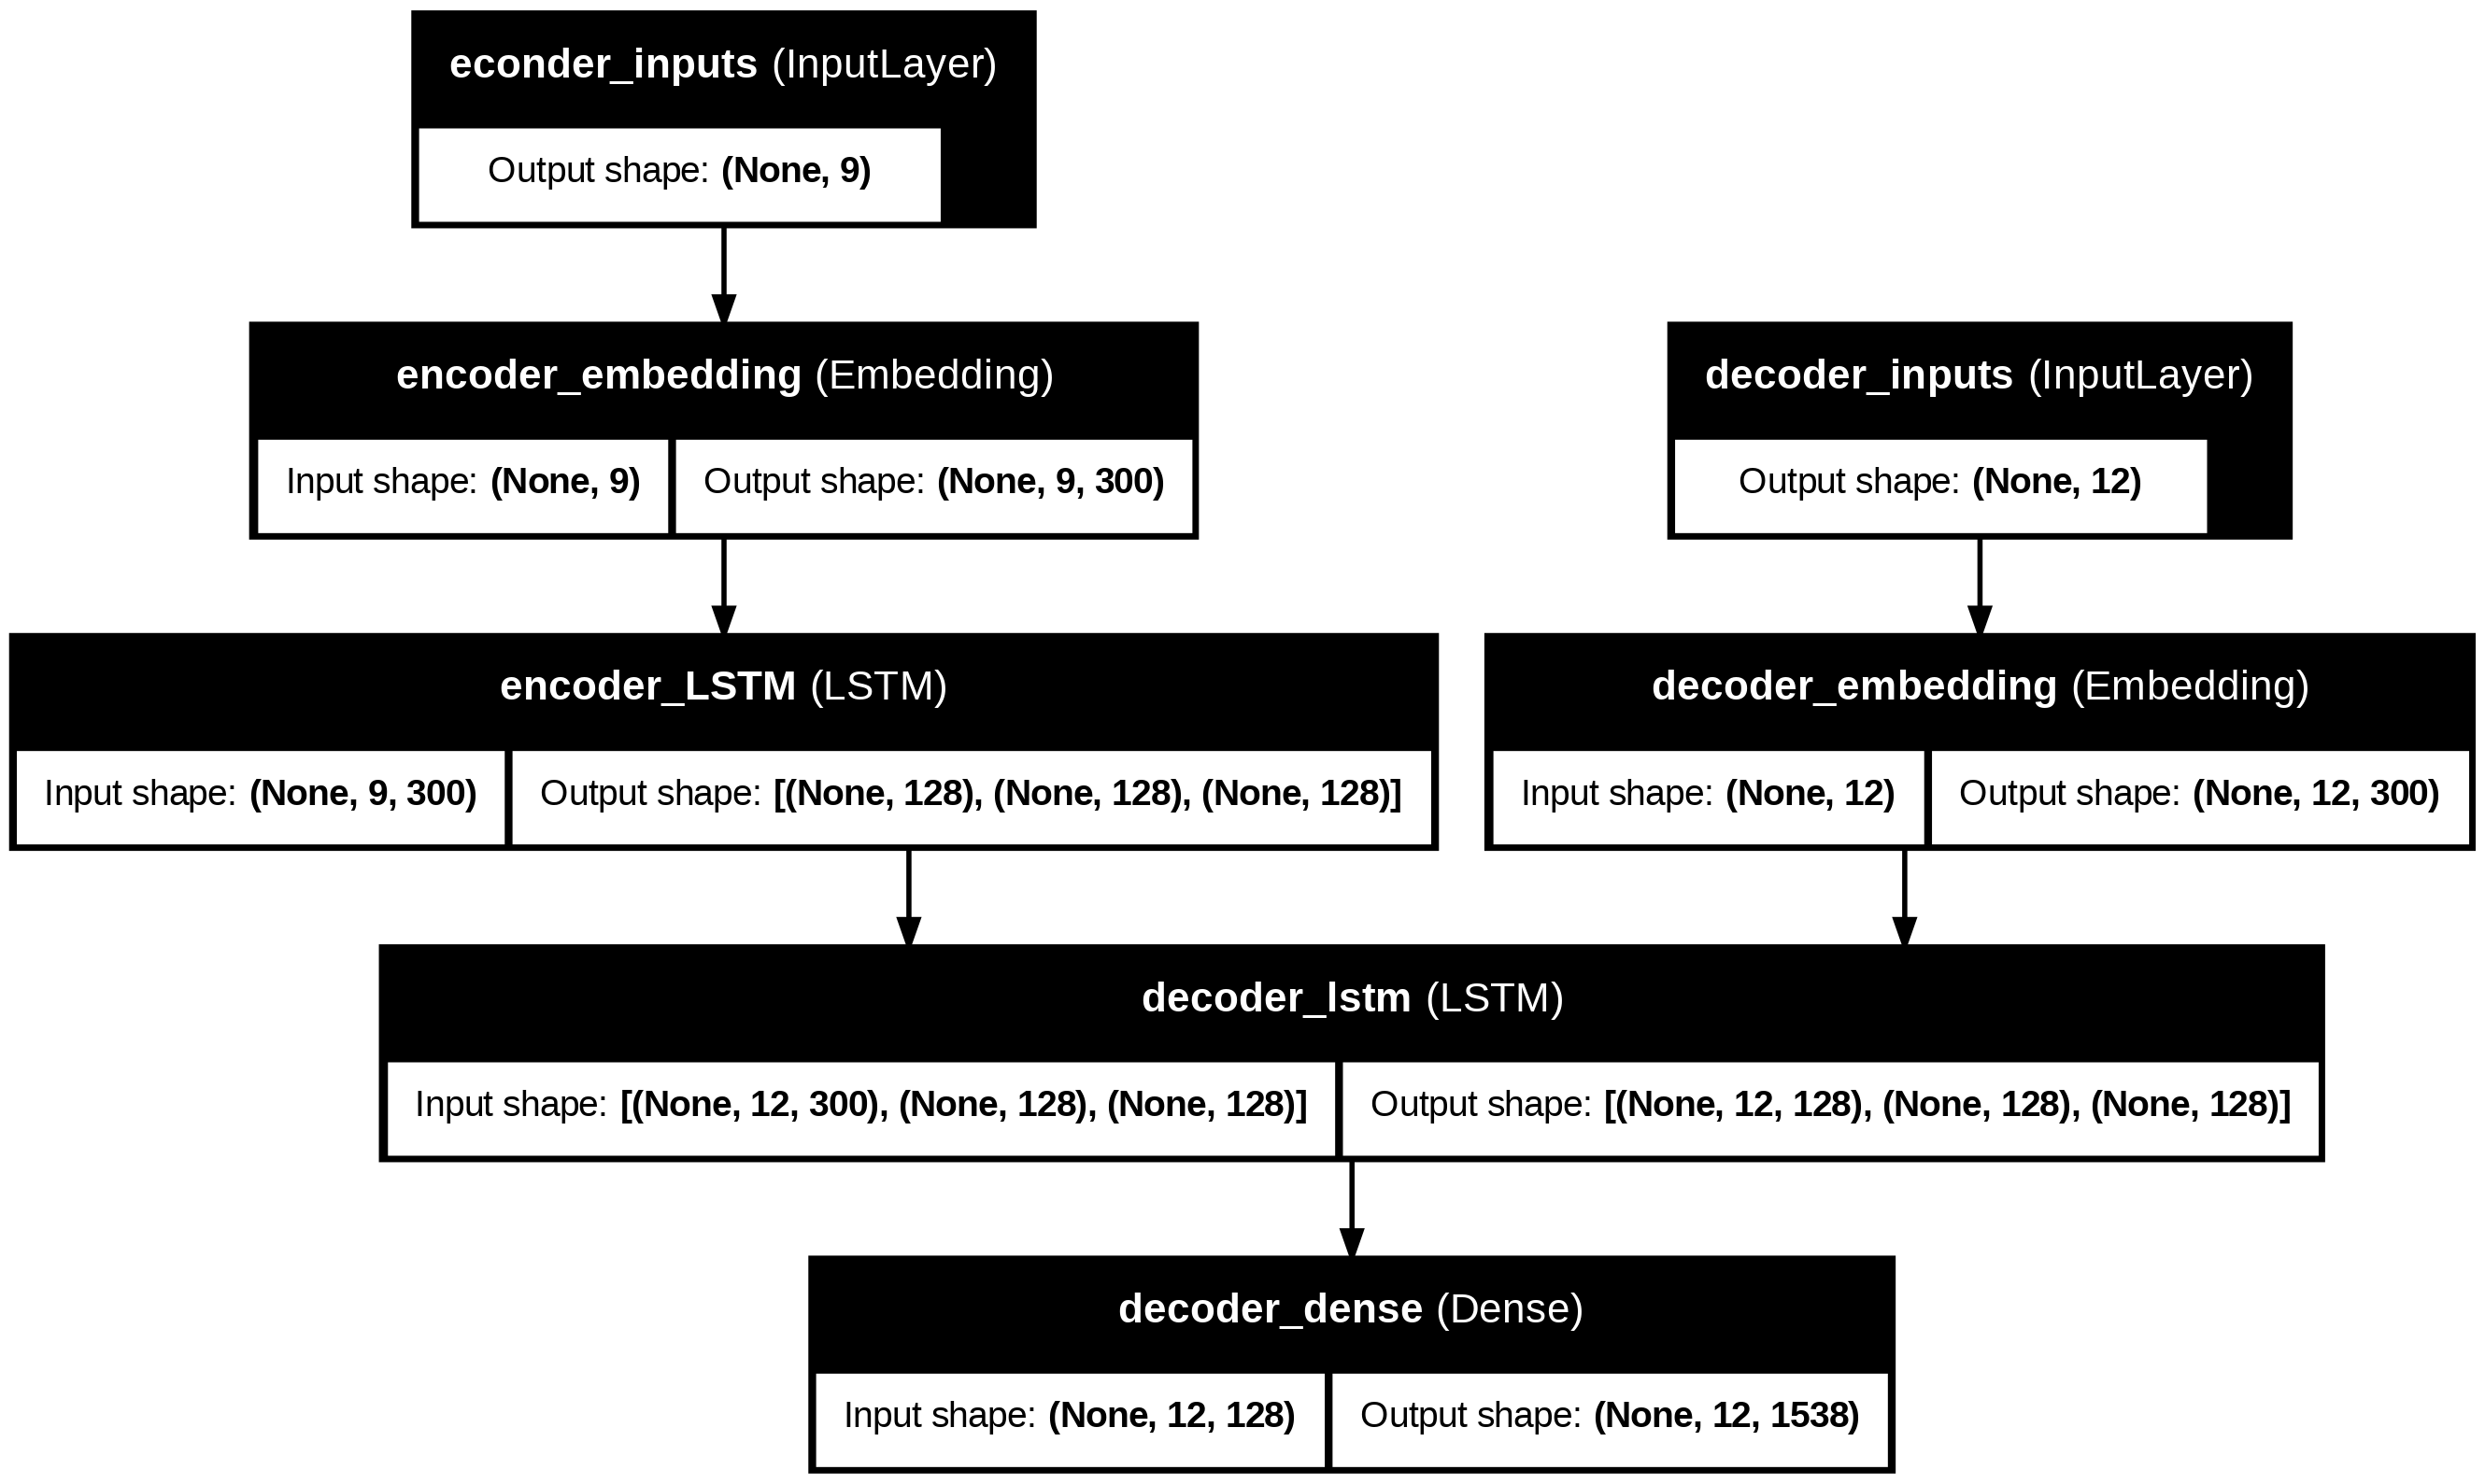

In [37]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

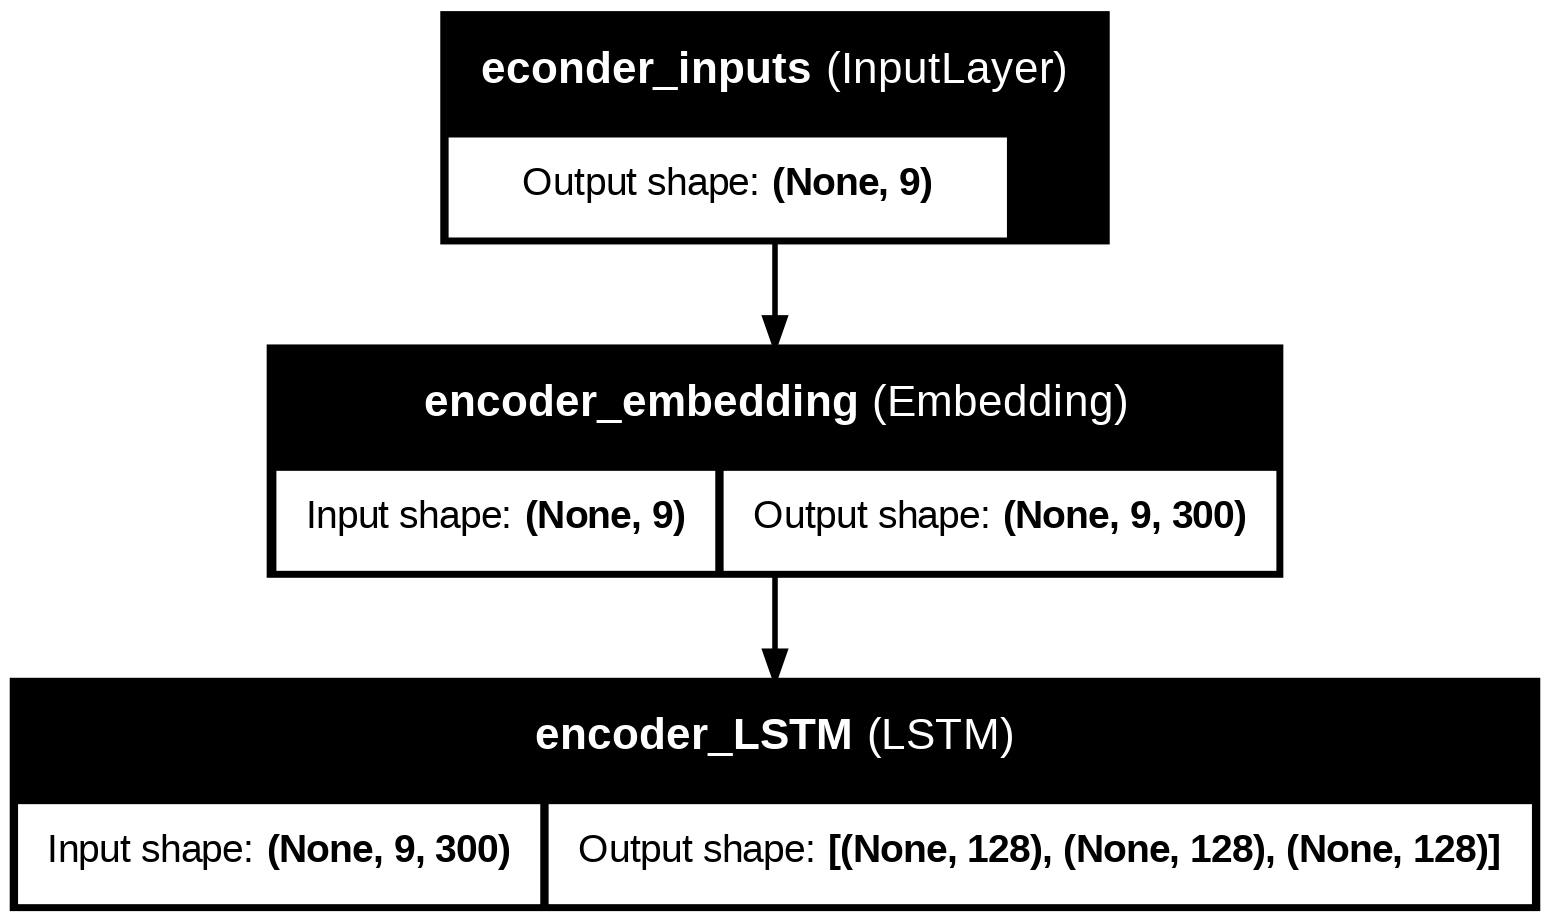

In [38]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

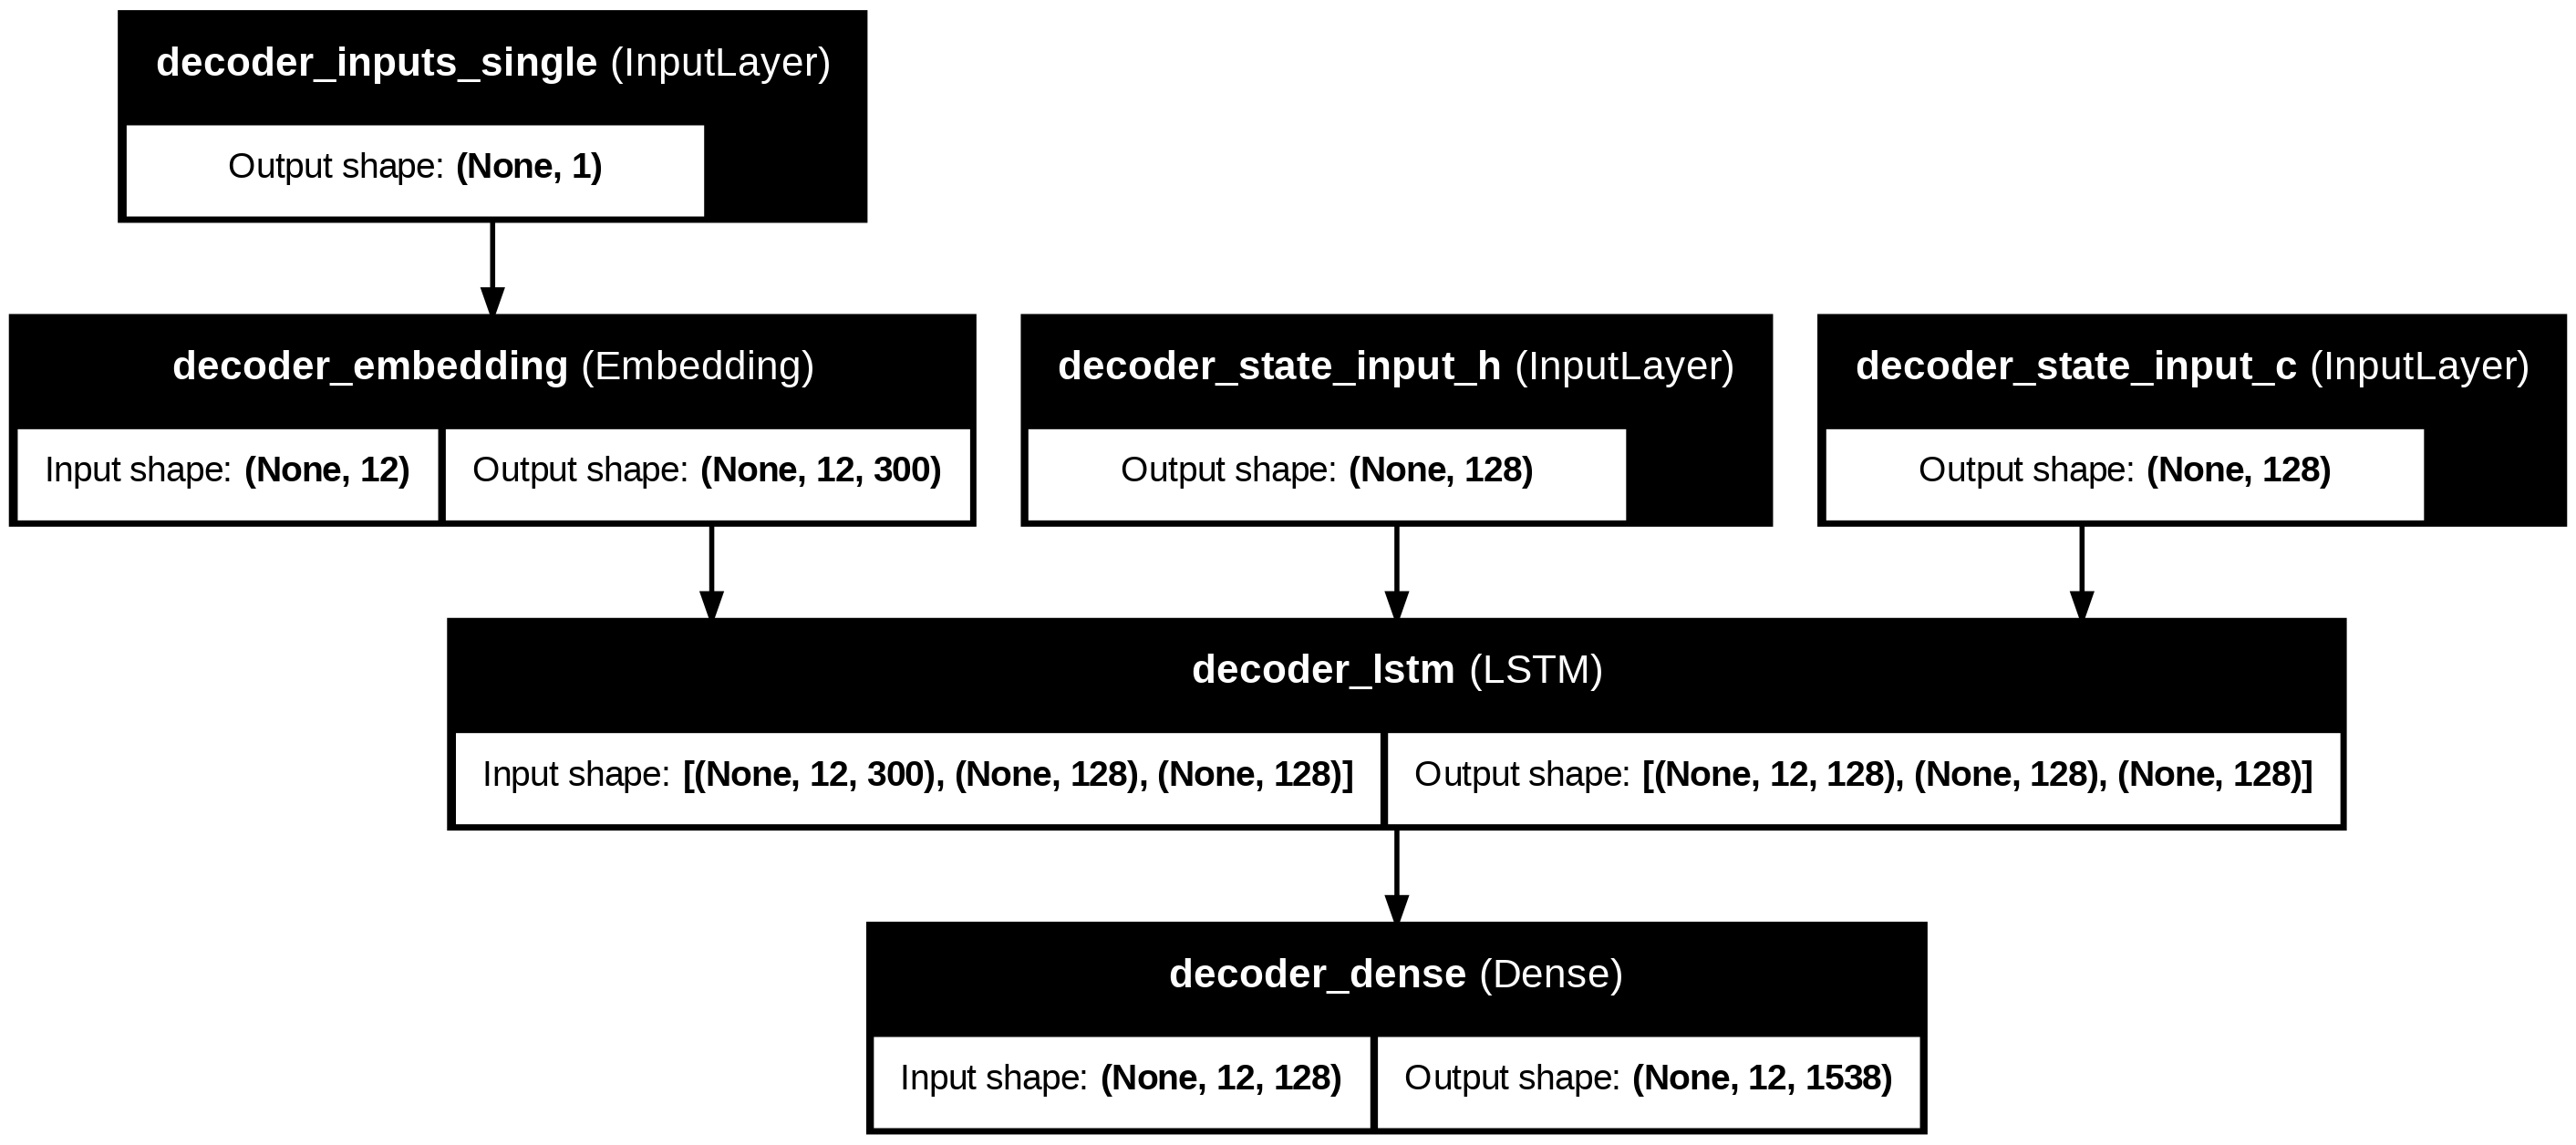

In [39]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,), name="decoder_state_input_h")
decoder_state_input_c = Input(shape=(n_units,), name="decoder_state_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,), name="decoder_inputs_single")
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=40,
    validation_split=0.2)

Epoch 1/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5283 - loss: 3.8020 - val_accuracy: 0.6499 - val_loss: 1.9794
Epoch 2/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6511 - loss: 1.8514 - val_accuracy: 0.6928 - val_loss: 1.8045
Epoch 3/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7120 - loss: 1.6021 - val_accuracy: 0.7128 - val_loss: 1.6703
Epoch 4/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7316 - loss: 1.4607 - val_accuracy: 0.7217 - val_loss: 1.6002
Epoch 5/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7500 - loss: 1.3443 - val_accuracy: 0.7281 - val_loss: 1.5465
Epoch 6/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7564 - loss: 1.2837 - val_accuracy: 0.7346 - val_loss: 1.5116
Epoch 7/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7638 - loss: 1.2293 - val_accuracy: 0.7385 - val_loss: 1.4818
Epoch 8/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7703 - loss: 1.1751 - val_acc

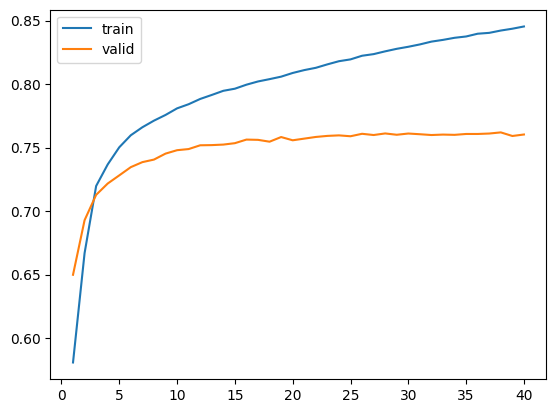

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [42]:
encoder_model.save('encoder128.keras')
decoder_model.save('decoder128.keras')

* **Comentario**: El proceso de entrenamiento muestra un buen aprendizaje inicial, sin embargo, exhibe signos de overfitting a partir de la época 19 aproximadamente. Mientras que la precisión en el entrenamiento sigue subiendo y la pérdida bajando, la pérdida de validación (val_loss) alcanza su punto mínimo (1.4001) y luego comienza a aumentar de forma consistente. Esto indica que el modelo ha comenzado a memorizar los datos de entrenamiento en lugar de generaliza.

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [43]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [44]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [45]:
def generate_answer(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [64]:
import tensorflow as tf # Asegúrate de importar tensorflow

def generate_answer_with_temp(input_seq, temperature=1.0):
    # Obtener los estados iniciales del encoder
    states_value = encoder_model.predict(input_seq)

    # Token de inicio '<sos>'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Token de final '<eos>'
    eos = word2idx_outputs['<eos>']

    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Aplicar temperatura a los logits (salida antes de softmax)
        logits = output_tokens[0, 0, :] / temperature

        # Muestrear un token de la nueva distribución
        probabilities = tf.nn.softmax(logits).numpy()
        idx = np.random.choice(len(probabilities), p=probabilities)

        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar estados y la siguiente entrada
        states_value = [h, c]
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [49]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
response = generate_answer(input_seq)
print('-')
print('Pregunta:', input_sentences[i])
print('Respuesta Real:', output_sentences[i].replace('<eos>', '').strip())

print('Respuesta Generada:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
-
Pregunta: yes
Respuesta Real: what do you do for a living
Respuesta Generada: wha do you do for a livi g


In [57]:
def test_chatbot_questions(questions_list, tokenizer, max_len, generation_function):
    print('======== Probando el chatbot con nuevas preguntas ========\n')

    for i, question in enumerate(questions_list):
        print(f'**** Pregunta {i+1} ****\n')

        # Preprocesar la pregunta (los mismos pasos que ya tenías)
        integer_seq = tokenizer.texts_to_sequences([question.lower()])
        encoder_sequence = pad_sequences(integer_seq, maxlen=max_len, padding='pre')

        # Generar respuesta
        response = generation_function(encoder_sequence)

        # Imprimir resultados
        print(f'Input: {question}')
        print(f'Response: {response}\n')

# --- MODO DE USO ---

# 1. Define tu lista de preguntas
questions = [
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?",
    "What is your name?",
    "How old are you?"
]
test_chatbot_questions(questions, input_tokenizer, max_input_len, generate_answer)

======== Probando el chatbot con nuevas preguntas ========

**** Pregunta 1 ****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Input: Do you read?
Response: i do o k ow wha o say

**** Pregunta 2 ****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Input: Do you have any pet?
Response: yes i do

**** Pregunta 3 ****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━

* **Comentario**: Los resultados de la inferencia muestra algunas respuestas que tienen sentido (pregunta 2), pero también tiende a mostrar un comportamiento donde el modelo tiende a generar respuestas repetitivas e irrelevantes como "i am a eacher, incluso sin importar la pregunta que se le haga.  Lo que nos hace inferir que en lugar de aprender a generalizar para construir respuestas coherentes, el modelo ha memorizado un conjunto limitado de frases.

### **Conclusiones**

Al desarrollar este trabajo se interioriza aprendizajes sobre el comportamiento de un modelo sequence-to-sequence. Se observó que, si bien el modelo aprende eficazmente de los datos de entrenamiento, muestra una marcada tendencia al overfifting. La tendencia del modelo a memorizar frases específicas y defectuosas como "i am a eacher", sugiere que su desempeño no solo se debe a las limitaciones de la arquitectura, sino que también es un reflejo  de la calidad, el tamaño y la diversidad del dataset utilizado, confirmando que la combinación de este enfoque y los datos es insuficiente para crear un agente conversacional coherente. En conclusión, para obtener mejores resultados, es necesario aumentar los datos (dataset más grande) y posteriormente aumentar la complejidad del modelo